In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data Preparation
First we ingested the Market Check Used Car Inventory data file containing used cars accross United States (~6.7 million instances with 38 features
Then we did initial data wraggling in SQLite and Alteryx (Removed columns with null values, single values, huge descriptive text values. Also instances with null values and 4 digit zipcodes

In [54]:
df = pd.read_csv('Desktop/GT/car_data_clean.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
df.head()

,id,vin_ss,price_fs,miles_fs,stock_no_ss,year_is,make_ss,model_ss,trim_ss,vehicle_type_ss,...,dom_is,dom_180_is,msrp_fs,dom_active_is,is_certified_is,fuel_type_ss,scraped_at_dts,status_date_dts,city_ss,state_ss
0,00000433-1e18-46f5-befa-cb338ff4c44c,4T1BF1FK8CU553915,12997,68475,UCJ2478,2012,Toyota,Camry,L,Car,...,36,36,12997,36,0,Regular Unleaded,2018-08-22T16:25:51Z,2018-09-23T18:43:48Z,Pineville,MO
1,00000847-d723-47ed-9dd6-e1d70088e35a,1C4RJEJT9EC221337,25942,70897,P32069,2014,Jeep,Grand Cherokee,Summit,SUV,...,131,97,25942,97,0,Flex-Fuel,2018-08-29T20:41:30Z,2018-09-23T22:08:26Z,Houston,TX
2,00000d32-faef-4643-b0e1-b5d91ef47c6a,1HGCP3F85BA018516,10488,91599,H42760A,2011,Honda,Accord,EX-L V-6,Car,...,64,64,12578,64,0,Regular Unleaded,2018-09-20T07:11:32Z,2018-09-24T01:34:40Z,Norwood,MA
3,00000ff5-58ae-4ce0-9b41-651d9e85b478,1FTEW1CP8GFB91564,29997,44394,D190109A,2016,Ford,F-150,XLT,Truck,...,220,24,29997,24,0,Regular Unleaded,2018-09-02T04:11:09Z,2018-09-23T21:15:07Z,Murrieta,CA
4,0000120b-8653-495d-9c6e-b1d80996bed7,1FMEU17L63LA06903,4990,173058,3LA06903,2003,Ford,Expedition,Eddie Bauer,SUV,...,46,46,4990,46,0,Regular Unleaded,2018-08-09T11:12:42Z,2018-09-23T17:48:19Z,Raleigh,NC


In [56]:
print(df.shape)

(3509809, 30)


# Picked the top 10 cars by volume for further analysis

In [57]:
df_vol = df['make_ss'].value_counts()
df_vol_10 = df_vol.head(10).to_frame(name='makes')
print(df_vol_10.index)

Index(['Chevrolet', 'Ford', 'Toyota', 'Nissan', 'Honda', 'Jeep', 'Hyundai',
       'GMC', 'BMW', 'Lexus'],
      dtype='object')


In [59]:
df_top10 = df.loc[df['make_ss'].isin(df_vol_10.index)]
print(df_top10.head())

                                     id             vin_ss  price_fs  \
0  00000433-1e18-46f5-befa-cb338ff4c44c  4T1BF1FK8CU553915     12997   
1  00000847-d723-47ed-9dd6-e1d70088e35a  1C4RJEJT9EC221337     25942   
2  00000d32-faef-4643-b0e1-b5d91ef47c6a  1HGCP3F85BA018516     10488   
3  00000ff5-58ae-4ce0-9b41-651d9e85b478  1FTEW1CP8GFB91564     29997   
4  0000120b-8653-495d-9c6e-b1d80996bed7  1FMEU17L63LA06903      4990   

   miles_fs stock_no_ss  year_is make_ss        model_ss      trim_ss  \
0     68475     UCJ2478     2012  Toyota           Camry            L   
1     70897      P32069     2014    Jeep  Grand Cherokee       Summit   
2     91599     H42760A     2011   Honda          Accord     EX-L V-6   
3     44394    D190109A     2016    Ford           F-150          XLT   
4    173058    3LA06903     2003    Ford      Expedition  Eddie Bauer   

  vehicle_type_ss   ...    dom_is dom_180_is msrp_fs  dom_active_is  \
0             Car   ...        36         36   12997     

In [65]:
df_top10.shape

(2417454, 30)

# Initial Features Selected
Created a dataframe with 15 features. Also filtered down to top 10 car makes by volume (~2.4 million instances)

In [66]:
df_top10 = df_top10[['price_fs', 'miles_fs', 'year_is', 'make_ss', 'model_ss', 'trim_ss', 
       'engine_size_ss',  'cylinders_is', 'interior_color_ss', 
       'exterior_color_ss', 'zip_is', 'msrp_fs', 'is_certified_is', 'fuel_type_ss', 'state_ss']]

In [68]:
df_top10.head()

,price_fs,miles_fs,year_is,make_ss,model_ss,trim_ss,engine_size_ss,cylinders_is,interior_color_ss,exterior_color_ss,zip_is,msrp_fs,is_certified_is,fuel_type_ss,state_ss
0,12997,68475,2012,Toyota,Camry,L,2.500,4,LIGHT GRAY,White,64856,12997,0,Regular Unleaded,MO
1,25942,70897,2014,Jeep,Grand Cherokee,Summit,5.700,8,BROWN,White,77065,25942,0,Flex-Fuel,TX
2,10488,91599,2011,Honda,Accord,EX-L V-6,3.500,6,Gray,Alabaster Silver Metallic,2062,12578,0,Regular Unleaded,MA
3,29997,44394,2016,Ford,F-150,XLT,2.700,6,Black,Ingot Silver Metallic,92562,29997,0,Regular Unleaded,CA
4,4990,173058,2003,Ford,Expedition,Eddie Bauer,5.400,8,Tan Leather,Blue,27603,4990,0,Regular Unleaded,NC


# Data Cleansing
Removed duplicates 

In [69]:
dedups = df_top10.drop_duplicates(['price_fs', 'miles_fs', 'year_is', 'make_ss', 'model_ss', 'trim_ss', 
       'engine_size_ss',  'cylinders_is', 'interior_color_ss', 
       'exterior_color_ss', 'zip_is', 'msrp_fs', 'is_certified_is', 'fuel_type_ss', 'state_ss'])

In [70]:
print(dedups.shape)

(2033496, 15)


# Data Visualization
Performed exploratory data analysis to better understand how data is distributed

Most Popular used car makes are Chevrolet and Ford

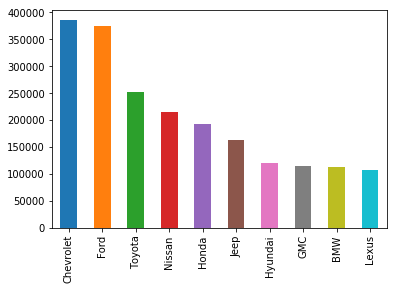

In [40]:
dedups['make_ss'].value_counts().plot(kind='bar')

Newer cars are more expensive than older cars. Expected.

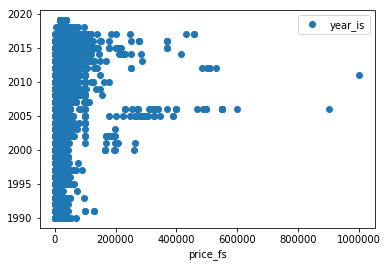

In [41]:
dedups.plot(x='price_fs', y='year_is', style='o')

Range and median prices per car type

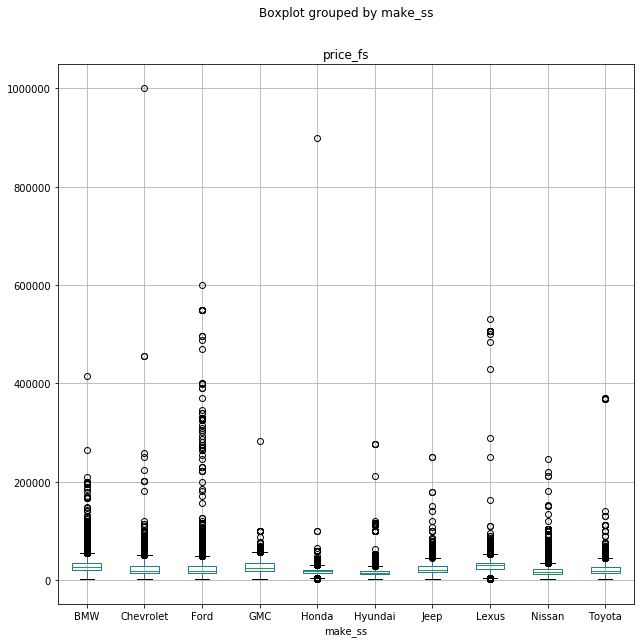

In [42]:
dedups.boxplot(column="price_fs", by="make_ss", figsize=(10,10))

Distribution among the various categorical features

make_ss
Chevrolet    384520
Ford         374833
Toyota       251598
Nissan       214915
Honda        192988
Name: make_ss, dtype: int64


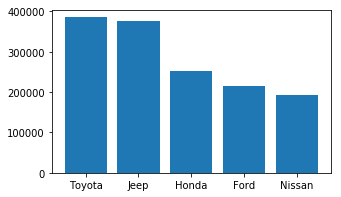

model_ss
F-150             96187
Silverado 1500    95057
CR-V              57828
Altima            55443
Escape            54927
Name: model_ss, dtype: int64


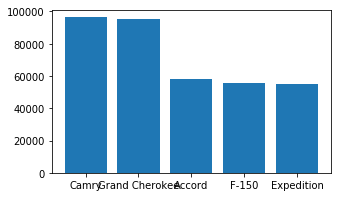

trim_ss
LT         177425
SE         170008
Base       153227
Limited    101450
S           64660
Name: trim_ss, dtype: int64


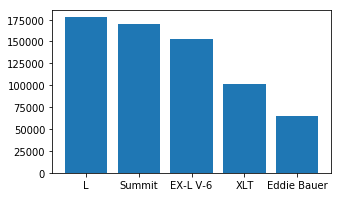

interior_color_ss
Black        227223
BLACK        211536
Jet Black    101571
Gray          81951
GRAY          71554
Name: interior_color_ss, dtype: int64


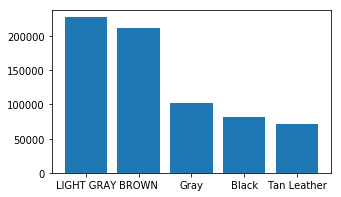

exterior_color_ss
Black           147104
White            76286
Summit White     61139
Silver           52424
Gray             51391
Name: exterior_color_ss, dtype: int64


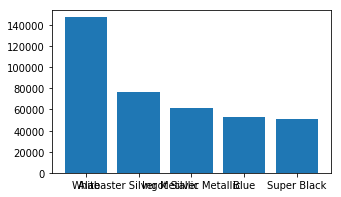

zip_is
30096    10998
28027    10449
27511    10424
27511     9932
28027     9896
Name: zip_is, dtype: int64


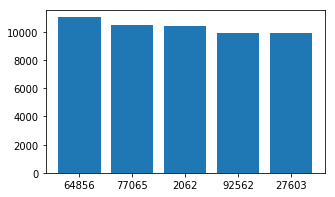

fuel_type_ss
Regular Unleaded    1353750
Flex-Fuel            319707
Premium Unleaded     304889
Diesel                45262
Gasoline               7850
Name: fuel_type_ss, dtype: int64


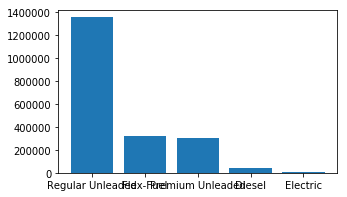

state_ss
NC    209639
FL    141091
TX    140171
CA    130087
GA     98460
Name: state_ss, dtype: int64


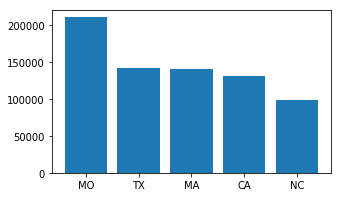

In [43]:
categories = ['make_ss', 'model_ss', 'trim_ss', 'interior_color_ss', 'exterior_color_ss', 'zip_is', 'fuel_type_ss', 'state_ss']

for i, c in enumerate(categories):
    v = dedups[c].unique()
    
    g = dedups.groupby(by=c)[c].count().sort_values(ascending=False)
    r = range(min(len(v), 5))

    print(g.head())
    plt.figure(figsize=(5,3))
    plt.bar(r, g.head()) 
    plt.xticks(r, v)
    plt.show()

# Feature Engineering

Converting categorical features into numeric values using Scikit Learn

In [20]:
labels = ['make_ss', 'model_ss', 'trim_ss', 'interior_color_ss', 'exterior_color_ss', 'zip_is', 'fuel_type_ss', 'state_ss']
les = {}

for l in labels:
    les[l] = LabelEncoder()
    les[l].fit(dedups[l].astype(str))
    tr = les[l].transform(dedups[l].astype(str))
    
    dedups.loc[:, l + '_feat'] = pd.Series(tr, index=dedups.index)

labeled = dedups[['price_fs'
                        ,'miles_fs'
                        ,'year_is'
                        ,'cylinders_is'
                        ,'msrp_fs'
                        , 'is_certified_is'
                        , 'engine_size_ss'] 
                    + [x+"_feat" for x in labels]]

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Used pearson to see how the features are related to each other and more importantly to price so that the top 10 features influencing price can be fed into the model. Looks like state and zip have very little influence on price.

In [25]:
print(labeled.head())

   price_fs  miles_fs  year_is  cylinders_is  msrp_fs  is_certified_is  \
0     12997     68475     2012             4    12997                0   
1     25942     70897     2014             8    25942                0   
2     10488     91599     2011             6    12578                0   
3     29997     44394     2016             6    29997                0   
4      4990    173058     2003             8     4990                0   

   engine_size_ss  make_ss_feat  model_ss_feat  trim_ss_feat  \
0           2.500             9             63           400   
1           5.700             6            169           762   
2           3.500             4             27           288   
3           2.700             2            125           917   
4           5.400             2            117           297   

   interior_color_ss_feat  exterior_color_ss_feat  zip_is_feat  \
0                   11015                   13312         5783   
1                    2233             

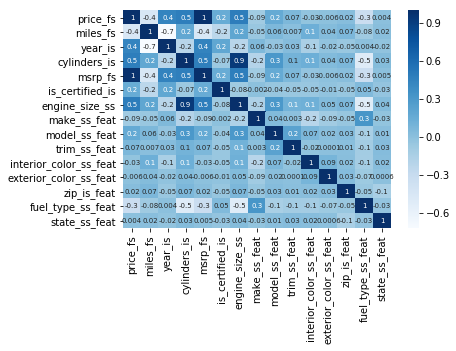

In [26]:
corr = labeled.corr(method='pearson')
sns.heatmap(corr, annot = True, fmt =".1g", annot_kws={"size": 7}, cmap = "Blues")

In [23]:
labeled.corr().loc[:,'price_fs'].abs().sort_values(ascending=False)[1:]

msrp_fs                  0.992
engine_size_ss           0.491
cylinders_is             0.485
year_is                  0.448
miles_fs                 0.448
fuel_type_ss_feat        0.320
model_ss_feat            0.171
is_certified_is          0.157
make_ss_feat             0.095
trim_ss_feat             0.065
interior_color_ss_feat   0.027
zip_is_feat              0.019
exterior_color_ss_feat   0.006
state_ss_feat            0.004
Name: price_fs, dtype: float64

# Model Selection
Used Random Forest Regressor with the 10 most influencing features to predict price (80/20 train test split)

In [27]:
y = labeled.price_fs

In [28]:
X = labeled[['miles_fs', 'year_is', 'cylinders_is', 
       'is_certified_is', 'engine_size_ss', 'make_ss_feat', 'model_ss_feat',
       'trim_ss_feat', 'fuel_type_ss_feat', 'interior_color_ss_feat']]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
rf = RandomForestRegressor()

In [31]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
y_pred = rf.predict(X_test)

In [33]:
explained_variance_score(y_pred, y_test)

0.9533233966505837

In [34]:
r2_score(y_pred, y_test)

0.9533233882500975

In [35]:
mean_squared_error(y_pred, y_test)

4990375.5672614155